YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Note d'analyse technique (sur 5): 3.18
Détail des scores [RSI, MACD, SMA, %B, ROC] : (0.1834130783138427, 1.0, 1.0, 0.0, 1.0)
Meilleurs hyperparamètres pour Random Forest : {'max_depth': 5, 'n_estimators': 50}
Meilleur ordre SARIMAX (p, d, q): (2, 1, 2)

MSE Entraînement :
LinReg : 44.8983
RF : 29.9430
SARIMAX : 693.2304

MSE Test :
LinReg : 72.9951
RF : 2856.8583
SARIMAX : 12599.2061

Biais moyen et variance (modèle Test) :
LinReg : Biais = -1.6745 ; Variance = 5506.9293
RF : Biais = -25.2835 ; Variance = 1152.3237
SARIMAX : Biais = -83.1771 ; Variance = 0.0000


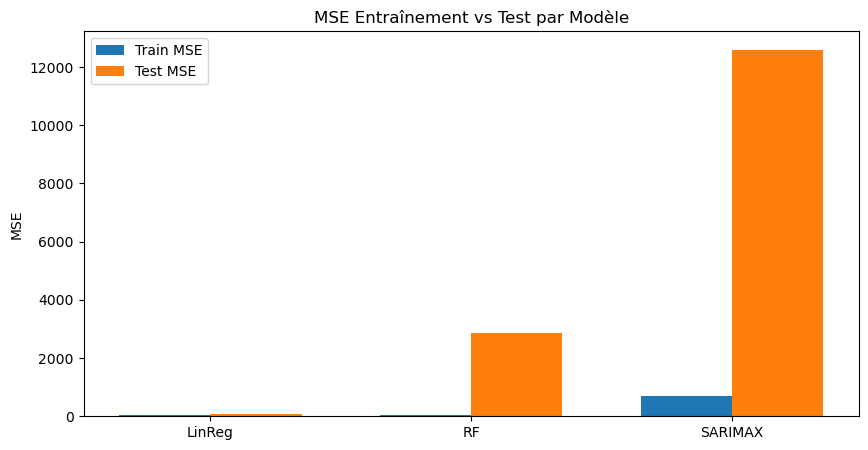

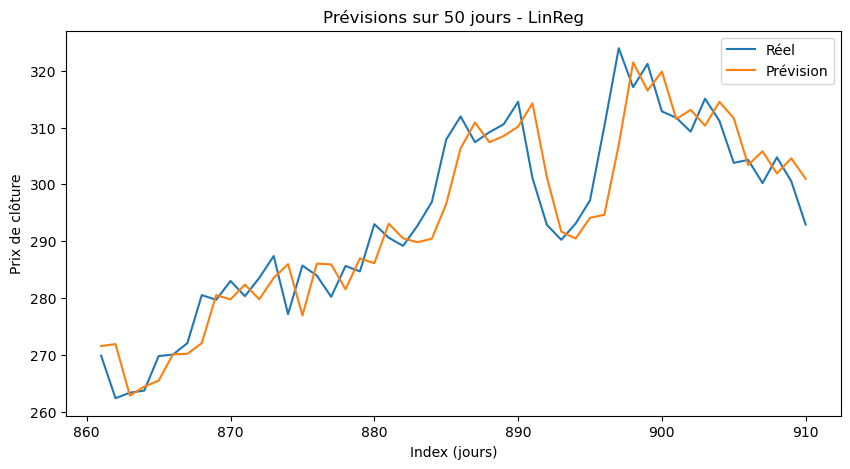

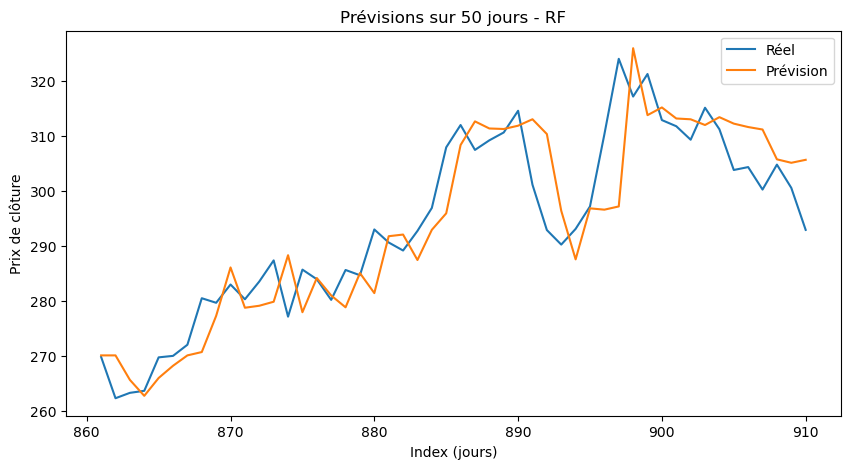

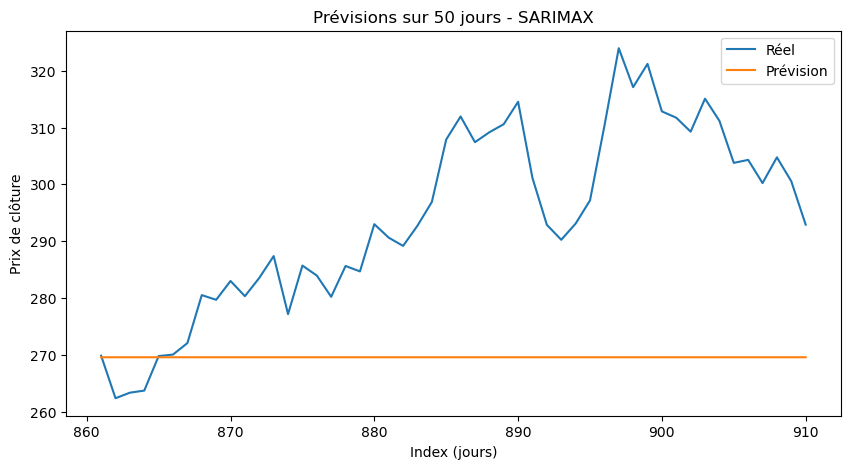


Le modèle sélectionné pour la prédiction est : LinReg

Prix de clôture du dernier jour : 517.36
Prix de clôture prédit pour le lendemain par LinReg : 522.66

Recommandation : INVESTIR


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import yfinance as yf  # pour télécharger des données
import warnings
warnings.filterwarnings('ignore')


########################################
# Étape 1 : Calcul des indicateurs techniques
########################################

def compute_indicators(df):
    """
    Pour un dataframe possédant les colonnes : date, open, high, low, close, volume,
    on calcule ici 5 indicateurs : SMA, EMA, RSI, MACD, Bandes de Bollinger (%B) et le ROC.
    """
    # --- SMA : moyenne mobile simple sur 20 jours ---
    df['sma20'] = df['close'].rolling(window=20).mean()

    # --- EMA : moyenne mobile exponentielle sur 12 jours (pour MACD) ---
    df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()

    # --- RSI sur 14 jours ---
    delta = df['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-10)  # éviter la division par zéro
    df['rsi14'] = 100 - (100 / (1 + rs))

    # --- MACD : différence entre EMA12 et EMA26 ---
    df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema26']

    # --- Bandes de Bollinger ---
    df['std20'] = df['close'].rolling(window=20).std()
    df['upperband'] = df['sma20'] + 2 * df['std20']
    df['lowerband'] = df['sma20'] - 2 * df['std20']
    df['percentb'] = (df['close'] - df['lowerband']) / (df['upperband'] - df['lowerband'] + 1e-10)

    # --- ROC : Rate Of Change sur 14 jours ---
    df['roc'] = df['close'].pct_change(periods=14)

    return df


########################################
# Étape 2 : Transformation des indicateurs en scores (note sur 5)
########################################

def score_rsi(rsi):
    if rsi < 30:
        return 1.0
    elif rsi > 70:
        return 0.0
    else:
        return (70 - rsi) / 40

def score_macd(macd):
    return 1.0 if macd > 0 else 0.0

def score_sma(close, sma):
    return 1.0 if close > sma else 0.0

def score_bbands(percentb):
    if percentb < 0.2:
        return 1.0
    elif percentb > 0.8:
        return 0.0
    else:
        return 1 - ((percentb - 0.2) / 0.6)

def score_roc(roc):
    return 1.0 if roc > 0 else 0.0

def calculate_technical_score(latest_data):
    score_rsi_val = score_rsi(latest_data['rsi14'])
    score_macd_val = score_macd(latest_data['macd'])
    score_sma_val  = score_sma(latest_data['close'], latest_data['sma20'])
    score_bbands_val = score_bbands(latest_data['percentb'])
    score_roc_val = score_roc(latest_data['roc'])
    total_score = score_rsi_val + score_macd_val + score_sma_val + score_bbands_val + score_roc_val
    return total_score, (score_rsi_val, score_macd_val, score_sma_val, score_bbands_val, score_roc_val)


########################################
# Préparation des données pour la prédiction
########################################

def prepare_features(df):
    df_feat = df.copy()
    df_feat['target'] = df_feat['close'].shift(-1)
    df_feat.dropna(inplace=True)
    features = ['open', 'high', 'low', 'close', 'volume', 'sma20', 'ema12', 'rsi14', 'macd', 'percentb', 'roc']
    X = df_feat[features]
    y = df_feat['target']
    return X, y

def train_test_split_time_series(X, y, test_size=0.2):
    split_index = int(len(X) * (1 - test_size))
    X_train = X.iloc[:split_index]
    y_train = y.iloc[:split_index]
    X_test  = X.iloc[split_index:]
    y_test  = y.iloc[split_index:]
    return X_train, X_test, y_train, y_test


########################################
# Modélisation
########################################

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    return model, y_train_pred, y_test_pred

def model_random_forest(X_train, y_train, X_test):
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    y_train_pred = best_rf.predict(X_train)
    y_test_pred  = best_rf.predict(X_test)
    return best_rf, y_train_pred, y_test_pred, grid_search.best_params_

def model_sarimax(y_train, y_test):
    best_aic = np.inf
    best_order = None
    best_model = None
    orders = [(1,1,1), (2,1,2), (1,0,1), (2,0,2)]
    for order in orders:
        try:
            model = sm.tsa.statespace.SARIMAX(y_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_model = model_fit
        except Exception as e:
            continue
    y_train_pred = best_model.predict(start=y_train.index[0], end=y_train.index[-1])
    y_test_pred  = best_model.predict(start=y_test.index[0], end=y_test.index[-1])
    return best_model, y_train_pred, y_test_pred, best_order


########################################
# Calcul des métriques et affichage des graphiques
########################################

def compute_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def compute_bias_variance(y_true, y_pred):
    bias = np.mean(y_pred) - np.mean(y_true)
    variance = np.var(y_pred)
    return bias, variance

def plot_forecast(y_test, y_test_pred, model_name, days=50):
    plt.figure(figsize=(10,5))
    plt.plot(y_test.iloc[:days].index, y_test.iloc[:days], label="Réel")
    plt.plot(y_test.iloc[:days].index, y_test_pred[:days], label="Prévision")
    plt.title(f"Prévisions sur 50 jours - {model_name}")
    plt.xlabel("Index (jours)")
    plt.ylabel("Prix de clôture")
    plt.legend()
    plt.show()

def plot_mse(mse_train, mse_test):
    labels = list(mse_train.keys())
    train_values = [mse_train[label] for label in labels]
    test_values = [mse_test[label] for label in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(10,5))
    plt.bar(x - width/2, train_values, width, label='Train MSE')
    plt.bar(x + width/2, test_values, width, label='Test MSE')
    plt.xticks(x, labels)
    plt.ylabel("MSE")
    plt.title("MSE Entraînement vs Test par Modèle")
    plt.legend()
    plt.show()


########################################
# Programme principal
########################################

def main():
    # Téléchargement des données via yfinance
    df = yf.download("META", start="2020-01-01", end="2024-04-09")
    # La donnée téléchargée a la date en index ; on la remet en colonne et on passe en minuscules
    df.reset_index(inplace=True)
    df.columns = [col[0].lower() if isinstance(col, tuple) else col.lower() for col in df.columns]

    
    # Si votre dataset contient plutôt "price" au lieu de "close", adaptez ici.
    # Dans cet exemple, nous utilisons 'close' comme valeur cible.
    # Si besoin, vous pouvez renommer la colonne "price" par "close" :
    # if 'price' in df.columns and 'close' not in df.columns:
    #     df.rename(columns={'price': 'close'}, inplace=True)
    
    # Tri par date (la colonne devrait s'appeler "date" maintenant)
    df.sort_values("date", inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Calcul des indicateurs techniques (Étape 1)
    df = compute_indicators(df)
    
    # Récupération de la dernière ligne pour l'analyse technique
    latest_data = df.iloc[-1]
    tech_score, individual_scores = calculate_technical_score(latest_data)
    print("Note d'analyse technique (sur 5):", round(tech_score, 2))
    print("Détail des scores [RSI, MACD, SMA, %B, ROC] :", individual_scores)
    
    # Préparation du dataset pour la prédiction
    X, y = prepare_features(df)
    X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, test_size=0.2)
    
    mse_train = {}
    mse_test = {}
    bias_dict = {}
    variance_dict = {}
    forecasts = {}
    
    # Modèle 1 : Régression linéaire
    lin_model, y_train_pred_lin, y_test_pred_lin = model_linear_regression(X_train, y_train, X_test)
    mse_train["LinReg"] = compute_mse(y_train, y_train_pred_lin)
    mse_test["LinReg"]  = compute_mse(y_test, y_test_pred_lin)
    bias, var = compute_bias_variance(y_test, y_test_pred_lin)
    bias_dict["LinReg"] = bias
    variance_dict["LinReg"] = var
    forecasts["LinReg"] = (y_test, y_test_pred_lin)
    
    # Modèle 2 : Random Forest
    rf_model, y_train_pred_rf, y_test_pred_rf, best_params = model_random_forest(X_train, y_train, X_test)
    mse_train["RF"] = compute_mse(y_train, y_train_pred_rf)
    mse_test["RF"]  = compute_mse(y_test, y_test_pred_rf)
    bias, var = compute_bias_variance(y_test, y_test_pred_rf)
    bias_dict["RF"] = bias
    variance_dict["RF"] = var
    forecasts["RF"] = (y_test, y_test_pred_rf)
    print("Meilleurs hyperparamètres pour Random Forest :", best_params)
    
    # Modèle 3 : SARIMAX
    sarimax_model, y_train_pred_sarimax, y_test_pred_sarimax, best_order = model_sarimax(y_train, y_test)
    mse_train["SARIMAX"] = compute_mse(y_train, y_train_pred_sarimax)
    mse_test["SARIMAX"]  = compute_mse(y_test, y_test_pred_sarimax)
    bias, var = compute_bias_variance(y_test, y_test_pred_sarimax)
    bias_dict["SARIMAX"] = bias
    variance_dict["SARIMAX"] = var
    forecasts["SARIMAX"] = (y_test, y_test_pred_sarimax)
    print("Meilleur ordre SARIMAX (p, d, q):", best_order)
    
    # Affichage des métriques
    print("\nMSE Entraînement :")
    for model_name in mse_train:
        print(f"{model_name} : {mse_train[model_name]:.4f}")
    print("\nMSE Test :")
    for model_name in mse_test:
        print(f"{model_name} : {mse_test[model_name]:.4f}")
    print("\nBiais moyen et variance (modèle Test) :")
    for model_name in bias_dict:
        print(f"{model_name} : Biais = {bias_dict[model_name]:.4f} ; Variance = {variance_dict[model_name]:.4f}")
    
    plot_mse(mse_train, mse_test)
    
    for model_name in forecasts:
        y_test_segment, y_test_pred_segment = forecasts[model_name]
        plot_forecast(y_test_segment, y_test_pred_segment, model_name, days=50)
    
    # Choix du meilleur modèle (celui qui a le plus faible MSE sur test)
    best_model_name = min(mse_test, key=mse_test.get)
    print(f"\nLe modèle sélectionné pour la prédiction est : {best_model_name}")
    
    if best_model_name == "LinReg":
        next_day_pred = lin_model.predict(X.iloc[[-1]])[0]
    elif best_model_name == "RF":
        next_day_pred = rf_model.predict(X.iloc[[-1]])[0]
    elif best_model_name == "SARIMAX":
        next_day_pred = sarimax_model.forecast(steps=1)[0]
    else:
        next_day_pred = None
    
    last_close = df.iloc[-1]['close']
    print(f"\nPrix de clôture du dernier jour : {last_close:.2f}")
    print(f"Prix de clôture prédit pour le lendemain par {best_model_name} : {next_day_pred:.2f}")
    
    if tech_score > 3 and next_day_pred > last_close:
        decision = "INVESTIR"
    else:
        decision = "NE PAS INVESTIR / VENDRE"
        
    print(f"\nRecommandation : {decision}")

if __name__ == "__main__":
    main()